## Colab 설정 및 필요 라이브러리 설치

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [3]:
!pip install pyupbit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 12.1 MB/s 


## 라이브러리 로드

In [4]:
import warnings
warnings.filterwarnings(action='ignore')

import datetime
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_absolute_error

from mlxtend.preprocessing import minmax_scaling

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rc('font', family='NanumBarunGothic') 

import lightgbm as lgb
from xgboost import XGBRegressor

In [5]:
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', None)
path = "/gdrive/My Drive/Brunch/"

### 데이터 로드

In [6]:
import pyupbit

coins = pyupbit.get_tickers(fiat="KRW")
len(coins)

114

In [7]:
## 코인 거래 데이터 다운로드를 위한 함수 설정

def get_df(coin):
  df = pyupbit.get_ohlcv(coin, count=365) # 1년치 데이터 활용
  df_4h = pyupbit.get_ohlcv(coin, interval = 'minute240', count=365*6) # 240분 단위 데이터 활용

  ## 변수 생성
  ## RSI 지표 생성
  df_4h['U'] = df_4h['close'] - df_4h['open']
  df_4h['D'] = df_4h['close'] - df_4h['open']
  df_4h['U'] = np.where(df_4h['U'] > 0, df_4h['U'], 0)
  df_4h['D'] = np.where(df_4h['D'] < 0, df_4h['D'], 0)

  df_4h.index = df_4h.index.strftime("%Y%m%d")
  df.index = df.index.strftime("%Y%m%d")

  df_A = df_4h.reset_index().groupby('index').mean()[['U','D']].reset_index()
  df_A.columns = ['index','AU','AD']

  df = pd.merge(df.reset_index(), df_A, on='index', how='left')
  df['price'] = df['close']*100 / df['open']

  df['RSI'] = df['AU'] / (df['AU'] + df['AD'])
  df.drop(['open','high','low','volume','AU','AD'], axis=1, inplace=True)

  df['RSI'] = df['RSI'].apply(lambda x: df[df['RSI'] != np.inf].max()['RSI'] if x == np.inf else x)
  df['RSI'].describe()

  ## 각 변수의 과거 시점 값을 변수로 생성
  df = pd.concat([df[['index','close','price']],minmax_scaling(df, columns=['value','RSI'])], axis=1)
  lag = np.arange(1,30).tolist()

  close_cols = ['close_' + str(a) for a in lag]
  value_cols = ['value_' + str(a) for a in lag]
  RSI_cols = ['RSI_' + str(a) for a in lag]

  data = pd.DataFrame()
  data['date'] = df['index']
  data['name'] = coin.split('-')[1]

  data['close'] = df['close']
  data['value'] = df['value']
  data['RSI'] = df['RSI']

  for a,b,c,d in zip(lag, close_cols, value_cols, RSI_cols):
    data[b] = df['close'].shift(int(a))
    data[c] = df['value'].shift(int(a))
    data[d] = df['RSI'].shift(int(a))

  time_now = datetime.datetime.now() + datetime.timedelta(days=-5)
  time_now = time_now.strftime("%Y%m%d")

  ## 5일 뒤 종가를 예측 변수로 설정
  data['target'] = df['close'].shift(-5)
  data['target'] = data['target']*100 / df['close']

  data['target'] = np.where(data['date'] <= time_now, data['target'], 100)

  data = data.dropna(axis=0)
  data.reset_index(drop = True, inplace=True)

  return data

In [8]:
## 설정 함수를 이용한 실제 데이터 셋 생성
df = pd.DataFrame()

for coin in tqdm(coins):
  tmp = get_df(coin)
  df = pd.concat([df,tmp])  

df.reset_index(drop = True, inplace=True)

100%|██████████| 114/114 [15:11<00:00,  7.99s/it]


### 머신러닝 모델링

In [9]:
## 학습, 예측 셋 구분 (최근 5일치 기준)
time_now = datetime.datetime.now() + datetime.timedelta(days=-5)
time_now = time_now.strftime("%Y%m%d")

Train = df[df['date'] <= time_now]
Test = df[df['date'] > time_now]

Train.reset_index(drop = True, inplace=True)
Test.reset_index(drop = True, inplace=True)

## 활용 변수 셋팅
cols = df.columns.tolist()
cols.remove('target')
cols.remove('name')
cols.remove('date')

## 학습용, 검증용 데이터셋 분리
X_train, X_valid, y_train, y_valid = train_test_split(Train[cols], Train['target'], train_size=0.8,random_state=42)

In [10]:
## XGB를 이용한 머신러닝
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_valid)
print(mean_absolute_error(y_valid, y_pred))

[10:06:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
9.496669551007113


In [11]:
## 예측값과 실제값의 차이 확인
tmp = pd.DataFrame()
tmp['pred'] = y_pred
tmp['true'] = y_valid

## 예측이 잘 된 경우와 되지 않은 경우 확인
tmp['diff'] = abs(tmp['pred'] - tmp['true'])
display(tmp.sort_values('diff', ascending = True).head(10), tmp.sort_values('diff', ascending = False).head(10))

,pred,true,diff
4032,101.311157,101.313131,0.001974
4774,99.275574,99.282297,0.006723
4756,99.376762,99.347826,0.028936
263,99.348091,99.392823,0.044732
3593,98.413879,98.360656,0.053224
6788,96.103149,96.165192,0.062042
3234,99.132248,99.216182,0.083934
4097,101.406075,101.494130,0.088056
3021,99.033203,99.124650,0.091447
34,101.214943,101.115613,0.099330


,pred,true,diff
4982,98.749550,204.000000,105.250450
3208,99.848045,177.248677,77.400632
6425,162.295532,92.768248,69.527285
3210,101.157272,170.078125,68.920853
4984,100.489006,152.849741,52.360735
1043,98.822281,150.451807,51.629526
6650,98.591492,149.848943,51.257451
1045,100.921242,151.170047,50.248805
3211,99.369240,149.398396,50.029156
5763,99.101097,147.773279,48.672182


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


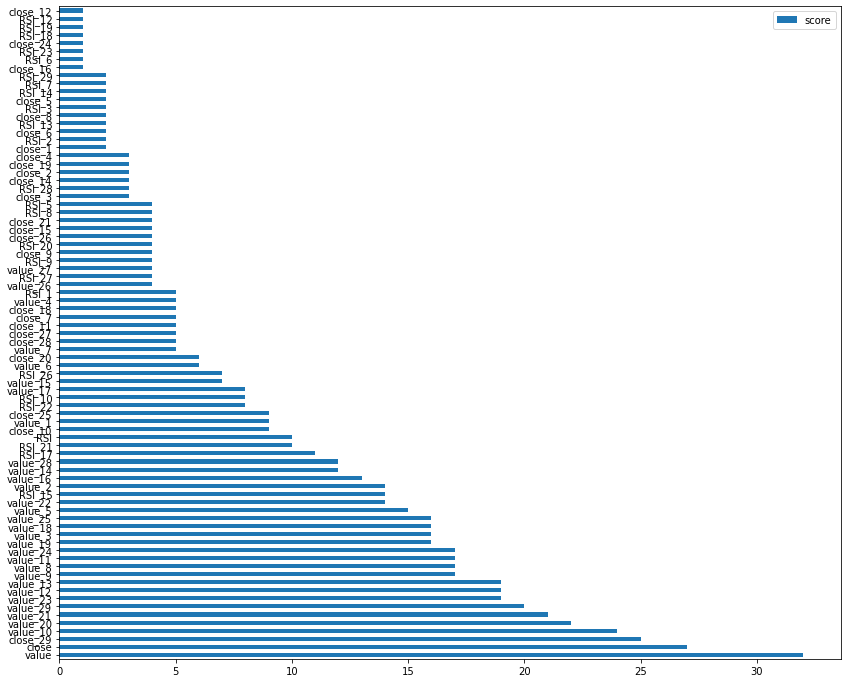

In [12]:
## 변수 중요도 확인
feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

tmp = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
tmp.plot(kind='barh', figsize=(14,12))

In [13]:
## LGBM을 활용한 머신러닝 적용

train, valid = train_test_split(Train, train_size=0.8,random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(train[cols], train['target'], train_size=0.8,random_state=42)
                                                      
## LGB
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_valid, label=y_valid)

## 파라미터 셋팅
params = {
            'learning_rate' : 0.05,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'mae',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }

## 모델 학습
model_t = lgb.train(params,
                train_ds,
                2000,
                val_ds,
                verbose_eval = 100,
                early_stopping_rounds = 100
                )

y_pred = model_t.predict(valid[cols])
print(mean_absolute_error(valid['target'], y_pred))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 9.47215
[200]	valid_0's l1: 9.42526
[300]	valid_0's l1: 9.39566
[400]	valid_0's l1: 9.37854
[500]	valid_0's l1: 9.34223
[600]	valid_0's l1: 9.3252
[700]	valid_0's l1: 9.29234
[800]	valid_0's l1: 9.27274
[900]	valid_0's l1: 9.24785
[1000]	valid_0's l1: 9.23192
[1100]	valid_0's l1: 9.2202
[1200]	valid_0's l1: 9.20327
[1300]	valid_0's l1: 9.2017
[1400]	valid_0's l1: 9.19834
[1500]	valid_0's l1: 9.18756
[1600]	valid_0's l1: 9.17604
[1700]	valid_0's l1: 9.16199
[1800]	valid_0's l1: 9.15782
[1900]	valid_0's l1: 9.1542
[2000]	valid_0's l1: 9.14555
Did not meet early stopping. Best iteration is:
[1996]	valid_0's l1: 9.14458
8.936808730311574


In [14]:
## 성능 확인
print(mean_absolute_error(valid['target'].values, y_pred))

8.936808730311574


In [15]:
## LGBM의 K-Fold 적용
train_set, valid_set = train_test_split(Train,train_size=0.85,random_state=42)
X_train = train_set[cols]
y_train = train_set['target']
X_valid = valid_set[cols]
y_valid = valid_set['target']

## 10 Fold Cross Validation
y_cat = pd.cut(y_train, 10, labels=range(10))
skf = KFold(5)

## 파라미터 셋팅
params = {
            'learning_rate' : 0.05,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'mae',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }

preds = []
preds_test = []

i = 1
## 실제 학습 진행
for tr_id, val_id in skf.split(X_train, y_cat) : 
    X_tr = X_train[cols].iloc[tr_id]
    y_tr = y_train.iloc[tr_id]

    train_x, valid_x, train_y, valid_y = train_test_split(X_tr, y_tr, train_size=0.8,random_state=42)
    train_ds = lgb.Dataset(train_x, label=train_y)
    val_ds = lgb.Dataset(valid_x, label=valid_y)

    print('{}번째 학습'.format(i))
    model = lgb.train(params,
                  train_ds,
                  2000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 ) 
    pred = model.predict(X_valid[cols])
    preds.append(pred)
    i += 1

    pred_test = model.predict(Test[cols])
    preds_test.append(pred_test)

## 예측값 생성 및 점수 확인
model_pred = np.mean(preds, axis = 0)
print(mean_absolute_error(y_valid, model_pred))

1번째 학습
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 9.16131
[200]	valid_0's l1: 9.10889
[300]	valid_0's l1: 9.08735
[400]	valid_0's l1: 9.07798
[500]	valid_0's l1: 9.05654
[600]	valid_0's l1: 9.03652
[700]	valid_0's l1: 8.98863
[800]	valid_0's l1: 8.97431
[900]	valid_0's l1: 8.95003
[1000]	valid_0's l1: 8.9328
[1100]	valid_0's l1: 8.92362
[1200]	valid_0's l1: 8.90531
[1300]	valid_0's l1: 8.89731
[1400]	valid_0's l1: 8.89053
Early stopping, best iteration is:
[1335]	valid_0's l1: 8.8884
2번째 학습
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 9.1773
[200]	valid_0's l1: 9.13352
[300]	valid_0's l1: 9.10289
[400]	valid_0's l1: 9.07639
[500]	valid_0's l1: 9.05686
[600]	valid_0's l1: 9.03964
[700]	valid_0's l1: 9.03118
[800]	valid_0's l1: 9.01673
[900]	valid_0's l1: 8.99913
[1000]	valid_0's l1: 8.99648
[1100]	valid_0's l1: 8.98293
[1200]	valid_0's l1: 8.98034
[1300]	valid_0's l1: 8.9795
[1400]	valid_0's l1: 8.96753
[1500]

### 결과 확인

In [16]:
## 최종 예측된 데이터셋 생성
final_pred = np.mean(preds_test, axis = 0)

final = pd.DataFrame()
final['coin'] = Test['name']
final['date'] = Test['date']
final['preds'] = final_pred

In [17]:
## 가장 상승할 것으로 예측되는 암호화폐 확인
final[final['date'] == final['date'].max()].sort_values('preds', ascending = False)[:10]

,coin,date,preds
269,ANKR,20220609,129.301468
464,HUM,20220609,117.372266
284,TT,20220609,113.693918
254,ENJ,20220609,110.840754
154,POLY,20220609,110.488095
44,SNT,20220609,110.028670
189,CVC,20220609,108.287646
504,XEC,20220609,108.236208
249,MOC,20220609,108.081183
279,ATOM,20220609,106.861012


In [18]:
## 가장 하락할 것으로 예측되는 암호화폐 확인
final[final['date'] == final['date'].min()].sort_values('preds', ascending = False)[:10]

,coin,date,preds
560,GMT,20220605,107.662555
0,BTC,20220605,106.309003
460,HUM,20220605,106.286924
270,AERGO,20220605,106.246127
490,AXS,20220605,104.997256
185,CVC,20220605,104.323357
265,ANKR,20220605,104.159299
280,TT,20220605,103.976463
535,NEAR,20220605,103.763992
350,KAVA,20220605,103.694203
